# Ejercicio 2
## Enunciado
Genere datasets usando el código "diagonal" desarrollado en la práctica de python (el otro conjunto desarrollado se llama "paralelo"), con C = 0.78 y d = 2. Genere un único conjunto de test con n = 10000. Genere 20 conjuntos de entrenamiento para cada uno de los siguientes valores de n: 125, 250, 500, 1000, 2000, 4000. Entrene árboles sobre estos conjuntos y guarde los resultados de error (1-accuracy) sobre los datos de entrenamiento y sobre el conjunto de test, como así también el tamaño del árbol (atributo tree_.node_count). En primer lugar genera una gráfica de las predicciones sobre los datos de test (plot x-y con colores para las clases) para un ejemplo de cada tamaño de conjunto de entrenamiento. Comente lo que se puede observar.

También genere dos gráficas: la primer gráfica tiene el training error y test error, y la segunda la cantidad de nodos en el árbol, todos como función de la longitud del conjunto de entrenamiento (utilice siempre el promedio de los 20 conjuntos de cada longitud dada). Sugerencia: usar escala logarítmica en el eje x, de la cantidad de datos.

Finalmente, repita todo el procedimiento completo usando como generador de datos el "paralelo". Incluya los resultados correspondientes en las mismas gráficas del diagonal. Discuta los resultados.

## Resolucion  - Caso diagonales.
Comencemos por generar los conjuntos de entrenamiento y los clasificadores para luego entrenarlos. Definimos una funcion general que dado un generador de puntos (como diagonales o paralelas) genera los conjuntos de entrenamiento.

In [13]:
import time
from Generadores import diagonales, paralelas
from Comunes import standardTree
from sklearn.metrics import zero_one_loss
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def generateTrainingSets(setSizes, setCount, generator, d, C):

    # Inicializamos la lista de conjuntos de entrenamiento
    trainingSets = [[] for _ in range(len(setSizes))]
    
    # Para cada tamaño de conjunto
    for i, setSize in enumerate(setSizes):

        # Generamos setCount conjuntos de entrenamiento
        for _ in range(setCount):
            trainingSets[i].append(generator(setSize, d, C))
            # time.sleep(1)    

    return trainingSets

In [15]:
def generateClassifiers(setSizesCount, setCount, trainingSets):
    # Creamos la lista de listas de clasificadores. La lista contiene setSizesCount listas con setCount clasificadores cada una.
    classifiers = [[] for _ in range(setSizesCount)]
    
    # Creamos los clasificadores
    for classifierList in classifiers:
        for i in range(setCount):
            classifierList.append(standardTree())
    
    # Entrenamos los clasificadores con su set de entrenamiento correspondiente.
    for i,classifierList in enumerate(classifiers):
        for j,classifier in enumerate(classifierList):
            classifier.fit(list(trainingSets[i][j]["Input"]), list(trainingSets[i][j]["Output"]))

    return classifiers

In [16]:
# Devuelve (trainingErrors, testErrors, treeSizes) como tupla.
def getPerformanceStats(trainingSets, setSizesCount, setCount, testSet, classifiers):
    # Creamos una lista de listas de errores y tamaños de los arboles. La lista contiene setSizesCount listas con setCount elementos cada una, de manera que 
    # trainingErrors[i][j] es el error de entrenamiento para el classifier[i][j]. Lo mismo vale para testErrors y treeSizes.
    # Esto sera la salida de nuestra funcion.
    trainingErrors = [[] for _ in range(setSizesCount)] 
    testErrors     = [[] for _ in range(setSizesCount)] 
    treeSizes      = [[] for _ in range(setSizesCount)] 
    
    # Para cada lista de conjuntos de entrenamiento
    for i in range(setSizesCount):
    
        # Y para cada conjunto de entrenamientos dentro de la lista
        for j in range(setCount):
    
            # Extraemos su clasificador asociado
            classifier = classifiers[i][j]
    
            # Predecimos los outputs sobre el mismo conjunto de entrenamiento y calculamos su loss
            trainingPredict = classifier.predict(list(trainingSets[i][j]["Input"]))
            trainingLoss = zero_one_loss(trainingSets[i][j]["Output"], trainingPredict)
    
            trainingErrors[i].append(trainingLoss)
    
            # Predecimos los outputs sobre el conjunto de test y calculamos su loss
            testPredict = classifier.predict(list(testSet["Input"]))
            testLoss = zero_one_loss(testSet["Output"], testPredict)
            
            testErrors[i].append(testLoss)
    
            # Y agragamos la cantidad de nodos del arbol.
            treeSizes[i].append(classifier.tree_.node_count)

    return (trainingErrors, testErrors, treeSizes)

In [17]:
def plotPerSize(trainingSets, classifiers, testSet, setSizes):

    testSet = list(testSet["Input"])
    fig, axes = plt.subplots(2, 3, figsize = (14, 8))
    axes = axes.flatten()
    for i, trainingSet in enumerate(trainingSets):
    
        # Predecimos sobre el conjunto de testeo
        predict = classifiers[i].predict(testSet)
    
        # Nos quedamos con las componentes de los clase 0
        x0 = np.array([e[0] for (i,e) in enumerate(testSet) if predict[i] == 0])
        y0 = np.array([e[1] for (i,e) in enumerate(testSet) if predict[i] == 0])
    
        # Y las componentes de los clase 1
        x1 = np.array([e[0] for (i,e) in enumerate(testSet) if predict[i] == 1])
        y1 = np.array([e[1] for (i,e) in enumerate(testSet) if predict[i] == 1])
    
        # Y plotteamos en el subplot correspondiente
        axes[i].scatter(x0, y0, color = "blue", s = 1)
        axes[i].scatter(x1, y1, color = "orange", s = 1)
    
        # Detalles del plot
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')
        axes[i].set_title(f'Clasificador entrenado con {setSizes[i]} datos')
    
    plt.tight_layout()
    plt.show()

In [18]:
def plotErrors(trainingErrors, testErrors, treeSizes, setSizes):
    
    # Una vez calculados los errores y cantidad de nodos para cada par de clasificador y conjunto de entrenamiento, tomamos las medias
    meanTrainingErrors = [np.mean(errorList) for errorList in trainingErrors]
    meanTestErrors     = [np.mean(errorList) for errorList in testErrors]
    meanTreeSizes      = [np.mean(sizeList)  for sizeList in treeSizes]
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 4))
    
    # Graficamos error de entrenamiento contra error de testeo
    axes[0].plot(setSizes, meanTrainingErrors, color="blue", marker='o', linestyle='-', linewidth=2, markersize=8, label='Error de entrenamiento')
    axes[0].plot(setSizes, meanTestErrors, color="orange", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo')
    axes[0].set_xlabel("Tamaño del conjunto de entrenamiento", fontsize=12)
    axes[0].set_ylabel("Tasa de error", fontsize=12)
    axes[0].set_title("Error de entrenamiento vs Error de testeo", fontsize=14)
    axes[0].grid(True, which="both", linestyle='--', alpha=0.5)
    axes[0].legend(fontsize=10)
    
    # Y los tamaños de los arboles
    axes[1].plot(setSizes, meanTreeSizes, color="red", marker='o', linestyle='-', linewidth=2, markersize=8)
    axes[1].set_xlabel("Tamaño del conjunto de entrenamiento", fontsize=12)
    axes[1].set_ylabel("Cantidad de nodos del árbol", fontsize=12)
    axes[1].set_title("Cantidad de nodos del árbol respecto al\n tamaño del conjunto de entrenamiento", fontsize=14)
    axes[1].grid(True, which="both", linestyle='--', alpha=0.5)
    
    # Marcamos los tamaños adecuados en el eje X y la escala logaritmica
    for ax in axes:
        ax.set_xscale("log")
        ax.set_xticks(setSizes)  
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # Esto cambia los numeros a notacion normal y no cientifica
        ax.tick_params(axis='x', which='minor', bottom=False)     # Esconde los ticks del eje que no son relevantes
    
    # Y setteamos los valores del eje Y para que matcheen con nuestros resultados
    axes[0].set_yticks(np.round(sorted(set(meanTrainingErrors + meanTestErrors)), decimals=2))
    axes[1].set_yticks(np.round(meanTreeSizes, decimals=0))  # 
    
    plt.show()



Definimos los parametros dados como constantes

In [19]:
setCount = 20
setSizes = [125, 250, 500, 1000, 2000, 4000]
setSizesCount = len(setSizes)
C = 0.78
d = 2
n = 10000

Creamos el conjunto de test, los conjuntos de entrenamiento para cada cada tamaño, y creamos y entrenamos los clasificadores con estos datos

In [20]:
testSetDiagonales = diagonales(n, d, C)

trainingSetsDiagonales = generateTrainingSets(setSizes, setCount, diagonales, d, C)

classifiersDiagonales = generateClassifiers(setSizesCount, setCount, trainingSetsDiagonales)

Ahora seleccionamos un par de conjunto de entrenamiento y clasificador asociados para cada tamaño y los graficamos.

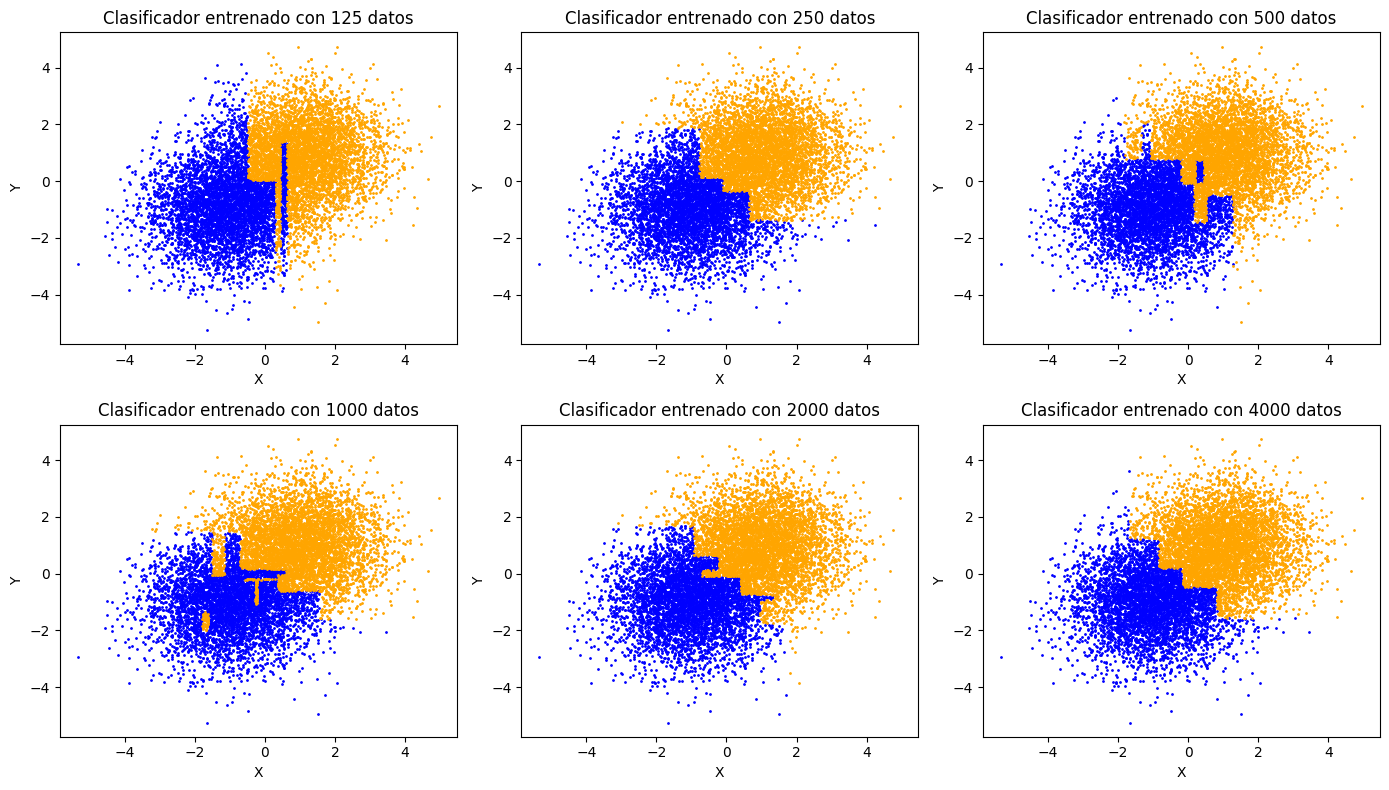

In [21]:
# Obtenemos el primero de cada tamaño
trainingSetsDiagonalesSample = [tSet[0] for tSet in trainingSetsDiagonales]
classifiersDiagonalesSample  = [cSet[0] for cSet in classifiersDiagonales] 

plotPerSize(trainingSetsDiagonalesSample, classifiersDiagonalesSample, testSetDiagonales, setSizes)

Para las mismas muestras graficamos también su error y la cantidad de nodos.

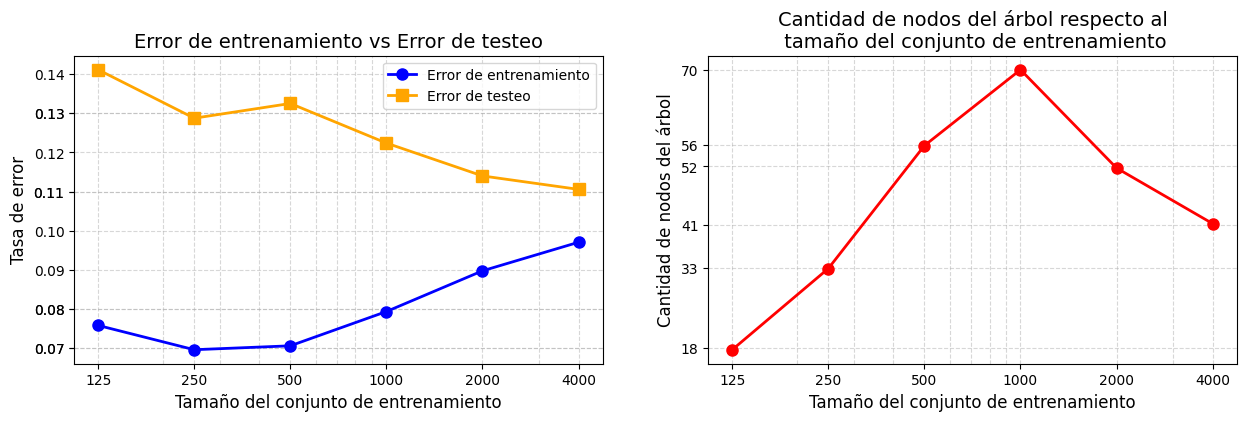

In [22]:
# Obtenemos los errores
(trainingErrorsDiagonales, testErrorsDiagonales, treeSizesDiagonales) = getPerformanceStats(trainingSetsDiagonales, setSizesCount, setCount, testSetDiagonales, classifiersDiagonales)

# Y plotteamos
plotErrors(trainingErrorsDiagonales, testErrorsDiagonales, treeSizesDiagonales, setSizes)

## Resolución - Caso paralelas.
Repetimos el procedimiento pero para el generador de paralelas.

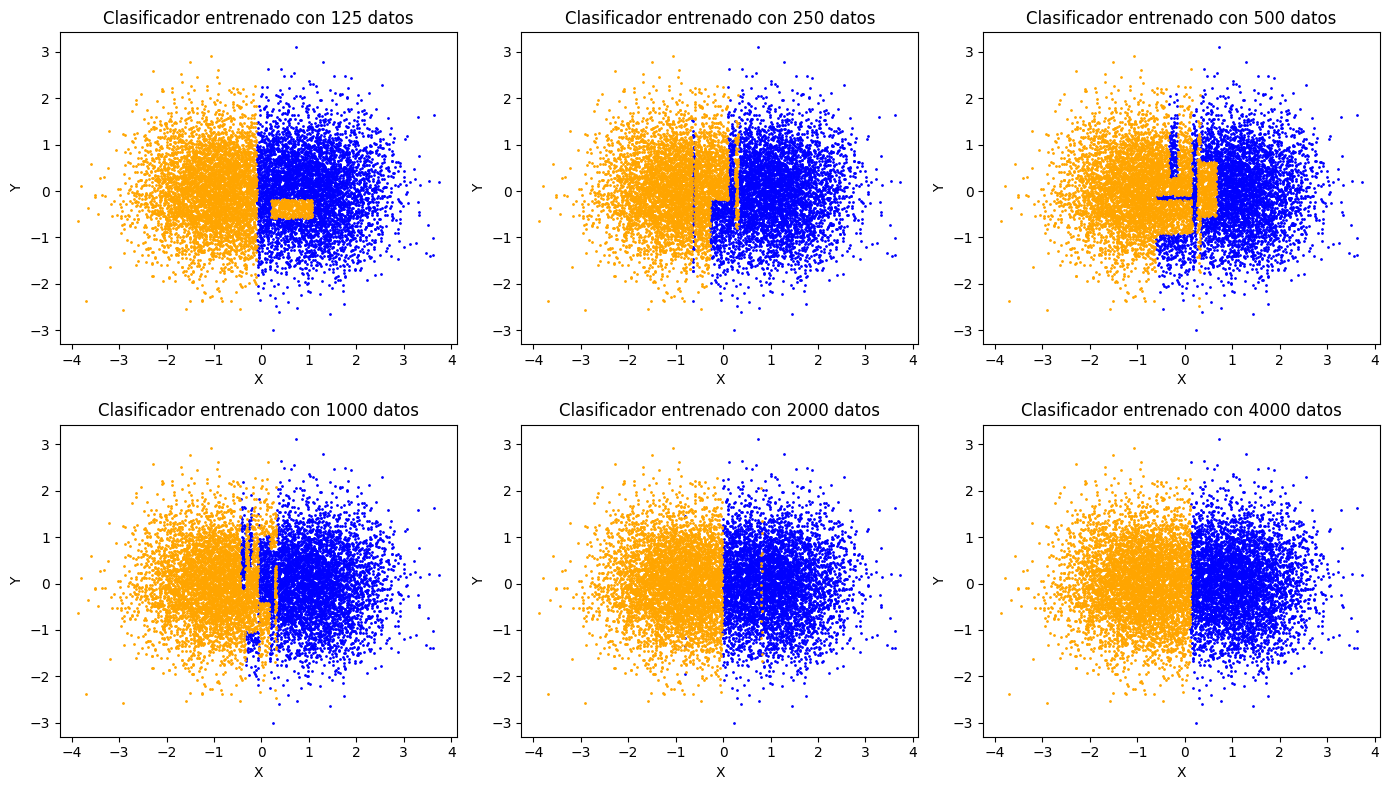

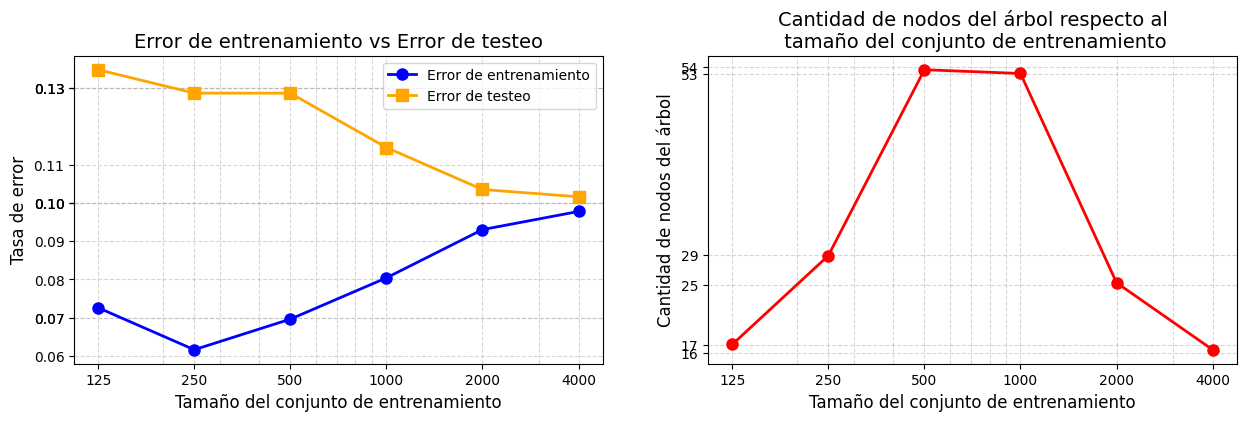

In [23]:
# Ya tenemos las funciones definidas, solo falta llamarlas con el nuevo generador
testSetParalelas = paralelas(n, d, C)
trainingSetsParalelas = generateTrainingSets(setSizes, setCount, paralelas, d, C)
classifiersParalelas = generateClassifiers(setSizesCount, setCount, trainingSetsParalelas)

# Evaluamos el error
(trainingErrorsParalelas, testErrorsParalelas, treeSizesParalelas) = getPerformanceStats(trainingSetsParalelas, setSizesCount, setCount, testSetParalelas, classifiersParalelas)

# Obtenemos un classifier particular para cada tamaño
trainingSetsParalelasSample = [tSet[0] for tSet in trainingSetsParalelas]
classifiersParalelasSample  = [cSet[0] for cSet in classifiersParalelas] 

# Imprimimos las predicciones
plotPerSize(trainingSetsParalelasSample, classifiersParalelasSample, testSetParalelas, setSizes)

# Y los graficos de error y cantidad de nodos
plotErrors(trainingErrorsParalelas, testErrorsParalelas, treeSizesParalelas, setSizes)

# Gráficos finales y conclusiones.
Veamos ahora en un mismo gráfico las tasas de error para los dos problemas.

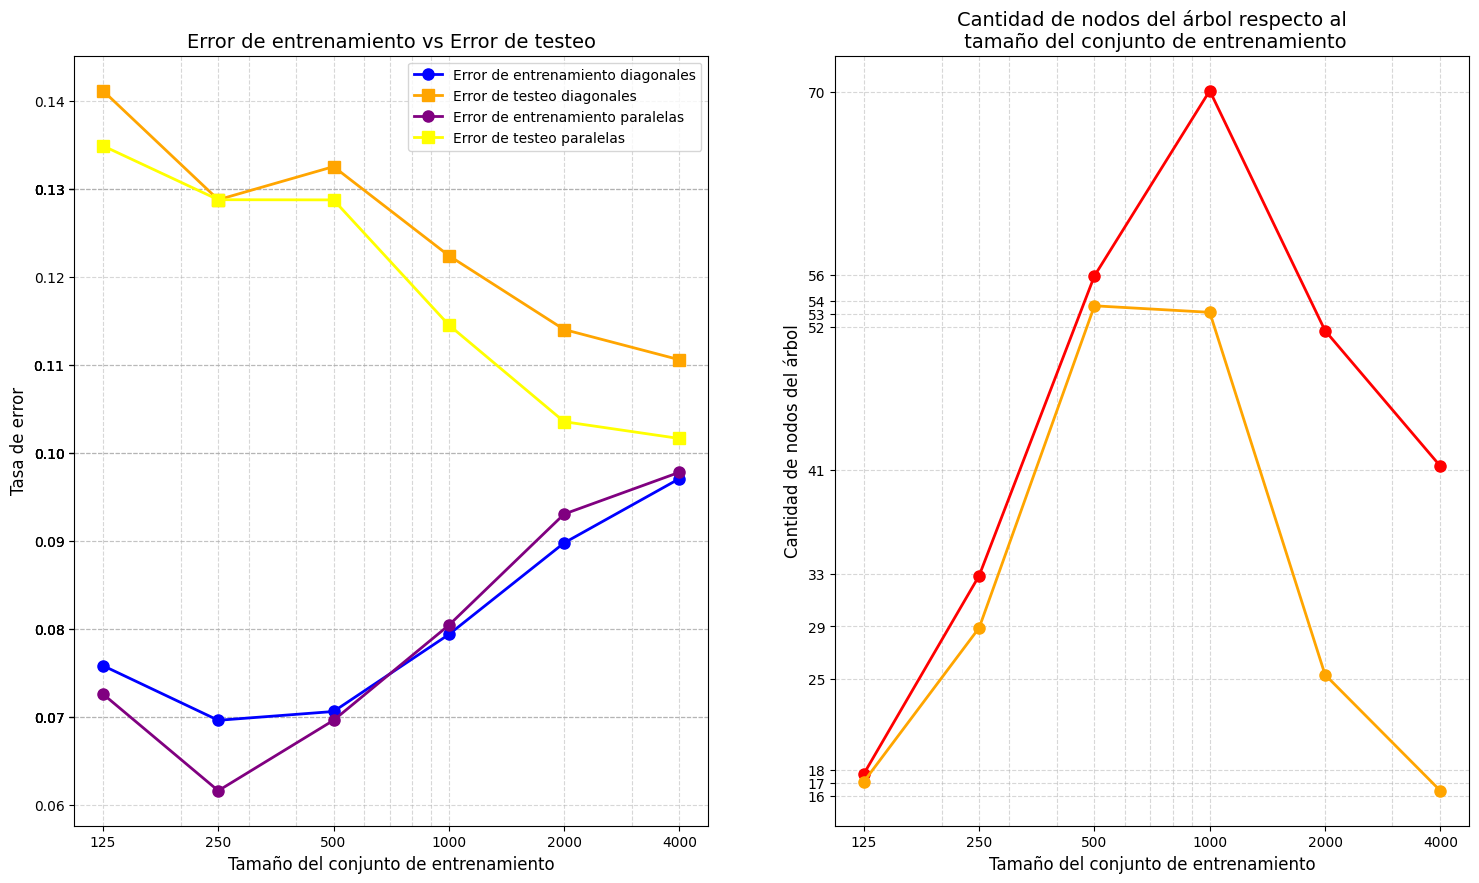

In [24]:
# Tomamos las medias
meanTrainingErrorsDiagonales = [np.mean(errorList) for errorList in trainingErrorsDiagonales]
meanTestErrorsDiagonales     = [np.mean(errorList) for errorList in testErrorsDiagonales]
meanTreeSizesDiagonales      = [np.mean(sizeList)  for sizeList in treeSizesDiagonales]
    
meanTrainingErrorsParalelas = [np.mean(errorList) for errorList in trainingErrorsParalelas]
meanTestErrorsParalelas     = [np.mean(errorList) for errorList in testErrorsParalelas]
meanTreeSizesParalelas      = [np.mean(sizeList)  for sizeList in treeSizesParalelas]
    
fig, axes = plt.subplots(1, 2, figsize = (18, 10))
    
# Graficamos error de entrenamiento contra error de testeo para diagonales
axes[0].plot(setSizes, meanTrainingErrorsDiagonales, color="blue", marker='o', linestyle='-', linewidth=2, markersize=8, label='Error de entrenamiento diagonales')
axes[0].plot(setSizes, meanTestErrorsDiagonales, color="orange", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo diagonales')

# Y para paralelas
axes[0].plot(setSizes, meanTrainingErrorsParalelas, color="purple", marker='o', linestyle='-', linewidth=2, markersize=8, label='Error de entrenamiento paralelas')
axes[0].plot(setSizes, meanTestErrorsParalelas, color="yellow", marker='s', linestyle='-', linewidth=2, markersize=8, label='Error de testeo paralelas')

axes[0].set_xlabel("Tamaño del conjunto de entrenamiento", fontsize=12)
axes[0].set_ylabel("Tasa de error", fontsize=12)
axes[0].set_title("Error de entrenamiento vs Error de testeo", fontsize=14)
axes[0].grid(True, which="both", linestyle='--', alpha=0.5)
axes[0].legend(fontsize=10)

# Y los tamaños de los arboles para ambos problemas
axes[1].plot(setSizes, meanTreeSizesDiagonales, color="red", marker='o', linestyle='-', linewidth=2, markersize=8)
axes[1].plot(setSizes, meanTreeSizesParalelas, color="orange", marker='o', linestyle='-', linewidth=2, markersize=8)

axes[1].set_xlabel("Tamaño del conjunto de entrenamiento", fontsize=12)
axes[1].set_ylabel("Cantidad de nodos del árbol", fontsize=12)
axes[1].set_title("Cantidad de nodos del árbol respecto al\n tamaño del conjunto de entrenamiento", fontsize=14)
axes[1].grid(True, which="both", linestyle='--', alpha=0.5)

# Marcamos los tamaños adecuados en el eje X y la escala logaritmica
for ax in axes:
    ax.set_xscale("log")
    ax.set_xticks(setSizes)  
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # Esto cambia los numeros a notacion normal y no cientifica
    ax.tick_params(axis='x', which='minor', bottom=False)     # Esconde los ticks del eje que no son relevantes

# Y setteamos los valores del eje Y para que matcheen con nuestros resultados
axes[0].set_yticks(np.round(sorted(set(meanTrainingErrorsParalelas + meanTestErrorsParalelas + meanTrainingErrorsDiagonales + meanTestErrorsDiagonales)), decimals=2))
axes[1].set_yticks(np.round(sorted(set(meanTreeSizesParalelas + meanTreeSizesDiagonales)), decimals=0))  # 

plt.show()


## Observaciones
Notemos que en ambos problemas el comportamiento es similar. Conforme aumentamos el tamaño del conjunto de entrenamiento los clasificadores muestran un mejor desempeño sobre el conjunto de testeo y un peor desempeño sobre el conjunto de entrenamiento. 

La mejora sobre la tasa de error sobre el conjunto de testeo puede atribuirse lógicamente a que, conforme aumentamos el tamaño del conjunto de entrenamiento, la muestra sobre la que entrenamos al clasificador se vuelve mas representativa de la población, por lo que el clasificador generaliza mejor.

Por otro lado, consideramos que la tasa de error de entrenamiento para ambos problemas empeora conforme aumenta el tamaño del conjunto de entrenamiento debido al uso de técnicas para prevenir el *overfitting* en el entrenamiento del modelo. Observando la gráfica de cantidad de nodos respecto al tamaño del conjunto de entrenamiento notamos que hasta el tamaño 1000 la cantidad de nodos aumenta pero luego comienza a decrecer, lo que podría indicar que en el entrenamiento se esta produciendo algún tipo de poda sobre el árbol.

Es razonable entonces pensar que conforme aumenta la cantidad de datos, y si se aplican técnicas de poda, el error de testeo y de entrenamiento converjan en un mismo valor, pues el comportamiento del clasificador no estará tan ajustado a los datos de entrenamiento.